# Imports

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans

# Selecting New Reference Data With Isolation Forests

In [133]:
a = pd.read_csv("all data/citizen/kerala.csv")

In [2]:
def select_reference_data(state, species, year, num_trees):
    
    df = pd.read_csv(f"all data/citizen/{state}.csv")
    df = df[df["Species_name"] == species]
    df = df[df["Year"] == int(year)]
    df = df.drop(["Date_of_observation", "Observation_ID", "User_id", "User_Tree_id", "Species_id", "State_name", "Species_name", "Year"], axis=1)
    df = df.reset_index(drop=True)
    
    model = IsolationForest(n_estimators = num_trees, verbose = 1, random_state = 42)
    
    new_ref_dict = {} # Saves closest citizen observations to centroids.
    cent = {} # Saves cluster centers of each week for future use
    
    for week in df["Week"].sort_values().unique():
        
        # Isolation Forests
        
        week_df = df[df["Week"] == week]
        week_df = week_df.drop("Week", axis=1)
        week_df = week_df.reset_index(drop=True)
        
        model.fit(week_df)
        preds = model.predict(week_df)

        week_df["Predictions"] = preds

        valid_data = week_df[week_df["Predictions"] == 1]
        valid_data = valid_data.reset_index(drop=True)
        
        # Clustering

        km = KMeans(n_clusters=1, random_state=42, n_init="auto")
        clusters = km.fit_predict(valid_data)
        centroids = km.cluster_centers_
        distances = []
        
        for i, row in valid_data.iterrows():
            cluster_label = clusters[i]
            centroid = centroids[0]
            relevant_values = row.values
            float_centroid = [float(val) for val in centroid]
            distance = np.linalg.norm(relevant_values - float_centroid)
            distances.append(distance)
            
        valid_data['Distance_to_Centroid'] = distances
        closest_point = valid_data[ valid_data["Distance_to_Centroid"] == min(valid_data['Distance_to_Centroid']) ]
        cent[week] = km.cluster_centers_
        new_ref_dict[week] = closest_point.iloc[0] # Adding citizen observation closest to centroid to new reference data dictionary for the associated week
        
    # Reformatting new reference data dictionary to be returned as a dataframe matching style of reference data
    new_ref_df = pd.DataFrame(new_ref_dict).T.sort_index()
    new_ref_df.insert(0,"Week",new_ref_df.index)
    return new_ref_df

# Selecting New Reference Data With Isolation Forests (Hyperparameters Included)

In [6]:
def select_reference_data(state, species, year, num_trees=500, contamination='auto', bootstrap=False):
    
    df = pd.read_csv(f"all data/citizen/{state}.csv")
    df = df[df["Species_name"] == species]
    df = df[df["Year"] == int(year)]
    df = df.drop(["Date_of_observation", "Observation_ID", "User_id", "User_Tree_id", "Species_id", "State_name", "Species_name", "Year"], axis=1)
    df = df.reset_index(drop=True)
    
    
    
    model = IsolationForest(n_estimators = num_trees, verbose = 1, contamination = contamination, 
                            bootstrap = bootstrap, random_state = 42)
    
    new_ref_dict = {} # Saves closest citizen observations to centroids.
    cent = {} # Saves cluster centers of each week for future use
    
    for week in df["Week"].sort_values().unique():
        
        # Isolation Forests
        
        week_df = df[df["Week"] == week]
        week_df = week_df.drop("Week", axis=1)
        week_df = week_df.reset_index(drop=True)
        
        model.fit(week_df)
        preds = model.predict(week_df)

        week_df["Predictions"] = preds

        valid_data = week_df[week_df["Predictions"] == 1]
        valid_data = valid_data.reset_index(drop=True)
        
        # Clustering

        km = KMeans(n_clusters=1, random_state=42, n_init="auto")
        clusters = km.fit_predict(valid_data)
        centroids = km.cluster_centers_
        distances = []
        
        for i, row in valid_data.iterrows():
            cluster_label = clusters[i]
            centroid = centroids[0]
            relevant_values = row.values
            float_centroid = [float(val) for val in centroid]
            distance = np.linalg.norm(relevant_values - float_centroid)
            distances.append(distance)
            
        valid_data['Distance_to_Centroid'] = distances
        closest_point = valid_data[ valid_data["Distance_to_Centroid"] == min(valid_data['Distance_to_Centroid']) ]
        cent[week] = km.cluster_centers_
        new_ref_dict[week] = closest_point.iloc[0] # Adding citizen observation closest to centroid to new reference data dictionary for the associated week
        
    # Reformatting new reference data dictionary to be returned as a dataframe matching style of reference data
    new_ref_df = pd.DataFrame(new_ref_dict).T.sort_index()
    new_ref_df.insert(0,"Week",new_ref_df.index)
    return new_ref_df

# Plotting Top 10 Species in Kerala in 2023 [Normal]

In [ ]:
import time
plot_path = "plots/selected_reference_data_isolation_forests"
#states = [state.replace('.csv','') for state in os.listdir("all data/citizen")]
states = ['kerala']
for state in states:
    #species_in_state = pd.read_csv(f"all data/citizen/{state}.csv")['Species_name'].unique()
    species_in_state = pd.read_csv(f"all data/citizen/{state}.csv")['Species_name'].value_counts().index[:10] # Top 10 prevalent species within that state
    for species in species_in_state:
        species_start_time = time.time()
        year = 2023 # !!! Do some stuff with years here (e.g. iterating over years and finding medin) !!!

        species_ref_df = select_reference_data(state, species, year)

        os.makedirs(f"{plot_path}/{state}/{species.replace(' ', '').replace('.', '').lower()}/bootstrap_{bootstrap}/contamination_{contamination}", exist_ok=True)

        phenophases = ['Leaves_fresh','Leaves_mature','Leaves_old','Flowers_bud','Flowers_open',
                       'Flowers_male','Flowers_Female','Fruits_unripe','Fruits_ripe','Fruits_open']
        for phenophase in phenophases:
            x = species_ref_df['Week']
            y = species_ref_df[phenophase]
            
            plt.plot(x, y, label=f'Selected citizen observations (selected reference data)')
            plt.xlabel('Week of the year (0-47)')
            plt.ylabel(f'{phenophase} value')
            plt.ylim(-2.2,2.2)
            plt.title(f'Annual {phenophase} reference data for {species} in {state}', fontsize=8)
            plt.legend()
            #plt.show()
            plt.savefig(f"{plot_path}/{state}/{species.replace(' ', '').replace('.', '').lower()}/bootstrap_{bootstrap}/contamination_{contamination}/{phenophase}_{year}")
            plt.close()
        print(f"{species} finished in {time.time()-species_start_time} seconds")

# Plotting Selected Reference vs. Citizen Data

In [69]:
import time
plot_path = "plots/ref_vs_cit_isolation_forests"
#states = [state.replace('.csv','') for state in os.listdir("all data/citizen")]
states = ['kerala']
for state in states:
    #species_in_state = pd.read_csv(f"all data/citizen/{state}.csv")['Species_name'].unique()
    species_in_state = pd.read_csv(f"all data/citizen/{state}.csv")['Species_name'].value_counts().index[:10] # Top 10 prevalent species within that state
    for species in species_in_state:
        species_start_time = time.time()
        year = 2023 # !!! Do some stuff with years here (e.g. iterating over years and finding medin) !!!

        species_ref_df = select_reference_data(state, species, year)

        os.makedirs(f"{plot_path}/{state}/{species.replace(' ', '').replace('.', '').lower()}", exist_ok=True)

        phenophases = ['Leaves_fresh','Leaves_mature','Leaves_old','Flowers_bud','Flowers_open',
                       'Flowers_male','Flowers_Female','Fruits_unripe','Fruits_ripe','Fruits_open']
        for phenophase in phenophases:
            ref_x = species_ref_df['Week']
            ref_y = species_ref_df[phenophase]
            cit_pcts = create_percentage_plots('kerala', species, 2023, phenophase)
            cit_x = list(cit_pcts.keys())
            cit_y = list(cit_pcts.values())
            
            fig, ax = plt.subplots()
            ax.plot(ref_x, ref_y, label=f'Selected citizen observations (selected reference data)',color='orange')
            ax.set_ylim(-0.01,2.02)
            ax.set_title(f'{phenophase} Reference Data vs. Percentage Observing Phenophase for {species} in {state} in {year}', fontsize=8)
            ax.set(xlabel='week index', ylabel='Phenophase Value')
            twin = ax.twinx()
            twin.plot(cit_x, cit_y, label=f'Percentage Observing Phenophase')
            twin.set_ylim(-0.01, 1.01)
            twin.set(ylabel='Percent')
            ax.legend()
            twin.legend(loc='lower left')
            plt.savefig(f"{plot_path}/{state}/{species.replace(' ', '').replace('.', '').lower()}/{phenophase}_{year}")
            plt.close()
                
        print(f"{species} finished in {time.time()-species_start_time} seconds")

Mango (all varieties)-Mangifera indica finished in 48.85904312133789 seconds
Jackfruit-Artocarpus heterophyllus finished in 47.873674154281616 seconds
Coconut palm-Cocos nucifera finished in 49.44746208190918 seconds
Tamarind-Tamarindus indica finished in 47.319135904312134 seconds
Indian Laburnum-Cassia fistula finished in 46.6449191570282 seconds
Amla-Phyllanthus emblica finished in 43.792783975601196 seconds
Jamun-Syzygium cumini finished in 44.868854999542236 seconds
Neem-Azadirachta indica finished in 45.04347014427185 seconds
Maulsari-Mimusops elengi finished in 43.54406809806824 seconds
Rain tree-Albizia saman finished in 43.959153175354004 seconds


# Plotting Top 10 Species in Kerala in 2023 Iterating Over Contamination

In [9]:
import time
start_time = time.time()
bootstrap = True
contamination_list = [0.001,0.002,0.005,0.01,0.02,0.05,0.1,0.2,0.5]
for contamination in contamination_list:
    epoch_start_time = time.time()
    plot_path = "plots/selected_reference_data_isolation_forests"
    #states = [state.replace('.csv','') for state in os.listdir("all data/citizen")]
    states = ['kerala']
    for state in states:
        #species_in_state = pd.read_csv(f"all data/citizen/{state}.csv")['Species_name'].unique()
        species_in_state = pd.read_csv(f"all data/citizen/{state}.csv")['Species_name'].value_counts().index[:10] # Top 10 prevalent species within that state
        for species in species_in_state:
            species_start_time = time.time()
            year = 2023 # !!! Do some stuff with years here (e.g. iterating over years and finding medin) !!!
            
            species_ref_df = select_reference_data(state, species, year, contamination=contamination, bootstrap=bootstrap)
            
            os.makedirs(f"{plot_path}/{state}/{species.replace(' ', '').replace('.', '').lower()}/bootstrap_{bootstrap}/contamination_{contamination}", exist_ok=True)
            
            phenophases = ['Leaves_fresh','Leaves_mature','Leaves_old','Flowers_bud','Flowers_open',
                           'Flowers_male','Flowers_Female','Fruits_unripe','Fruits_ripe','Fruits_open']
            for phenophase in phenophases:
                x = species_ref_df['Week']
                y = species_ref_df[phenophase]
                
                plt.plot(x, y, label=f'Selected citizen observation (selected reference data)')
                plt.xlabel('Week of the year (0-47)')
                plt.ylabel(f'{phenophase} value')
                plt.ylim(-2.2,2.2)
                plt.title(f'Annual {phenophase} reference data for {species} in {state}', fontsize=8)
                plt.legend()
                #plt.show()
                plt.savefig(f"{plot_path}/{state}/{species.replace(' ', '').replace('.', '').lower()}/bootstrap_{bootstrap}/contamination_{contamination}/{phenophase}_{year}")
                plt.close()
            print(f"{species} finished in {time.time()-species_start_time} seconds")
    print(f"*****\ncontamination = {contamination} finished in {time.time()-epoch_start_time} seconds\ntotal time elapsed: {time.time()-start_time} seconds\n*****")

Mango (all varieties)-Mangifera indica finished in 42.195014238357544 seconds
Jackfruit-Artocarpus heterophyllus finished in 41.96132826805115 seconds
Coconut palm-Cocos nucifera finished in 40.71319603919983 seconds
Tamarind-Tamarindus indica finished in 40.633050203323364 seconds
Indian Laburnum-Cassia fistula finished in 43.971985816955566 seconds
Amla-Phyllanthus emblica finished in 40.395867109298706 seconds
Jamun-Syzygium cumini finished in 39.84677720069885 seconds
Neem-Azadirachta indica finished in 40.63419508934021 seconds
Maulsari-Mimusops elengi finished in 39.49678587913513 seconds
Rain tree-Albizia saman finished in 40.879143953323364 seconds
*****
contamination = 0.001 finished in 411.35475492477417 seconds
total time elapsed: 411.3551480770111 seconds
*****
Mango (all varieties)-Mangifera indica finished in 42.07700300216675 seconds
Jackfruit-Artocarpus heterophyllus finished in 42.12473797798157 seconds
Coconut palm-Cocos nucifera finished in 41.817336082458496 seconds

# Plotting Only Mango in Kerala in 2023 Iterating Over n_estimators

In [19]:
import time
start_time = time.time()
num_trees_list = [50, 100, 200, 500,1000,2000,5000,10000]
for num_trees in num_trees_list:
    epoch_start_time = time.time()
    plot_path = "plots/selected_reference_data_isolation_forests"
    #states = [state.replace('.csv','') for state in os.listdir("all data/citizen")]
    states = ['kerala']
    for state in states:
        #species_in_state = pd.read_csv(f"all data/citizen/{state}.csv")['Species_name'].unique()
        #species_in_state = pd.read_csv(f"all data/citizen/{state}.csv")['Species_name'].value_counts().index[:10] # Top 10 prevalent species within that state
        species_in_state = ['Mango (all varieties)-Mangifera indica']
        for species in species_in_state:
            species_start_time = time.time()
            year = 2023 # !!! Do some stuff with years here (e.g. iterating over years and finding medin) !!!
            
            species_ref_df = select_reference_data(state, species, year, num_trees)
            
            os.makedirs(f"{plot_path}/trees_{num_trees}/{state}/{species.replace(' ', '').replace('.', '').lower()}", exist_ok=True)
            
            phenophases = ['Leaves_fresh','Leaves_mature','Leaves_old','Flowers_bud','Flowers_open',
                           'Flowers_male','Flowers_Female','Fruits_unripe','Fruits_ripe','Fruits_open']
            for phenophase in phenophases:
                x = species_ref_df['Week']
                y = species_ref_df[phenophase]
                cit_pct = 
                
                plt.plot(x, y, label=f'Selected citizen observation (selected reference data)')
                plt.xlabel('Week of the year (0-47)')
                plt.ylabel(f'{phenophase} value')
                plt.ylim(-2.2,2.2)
                plt.title(f'Annual {phenophase} reference data for {species} in {state}', fontsize=8)
                plt.legend()
                #plt.show()
                plt.savefig(f"{plot_path}/trees_{num_trees}/{state}/{species.replace(' ', '').replace('.', '').lower()}/{phenophase}_{year}")
                plt.close()
            print(f"{species} finished in {time.time()-species_start_time} seconds")
    print(f"*****\nn_estimators = {num_trees} finished in {time.time()-epoch_start_time} seconds\ntotal time elapsed: {time.time()-start_time} seconds\n*****")

Mango (all varieties)-Mangifera indica finished in 5.366149187088013 seconds
*****
n_estimators = 50 finished in 5.366253852844238 seconds
total time elapsed: 5.366577386856079 seconds
*****
Mango (all varieties)-Mangifera indica finished in 8.304078340530396 seconds
*****
n_estimators = 100 finished in 8.304295301437378 seconds
total time elapsed: 13.670883655548096 seconds
*****
Mango (all varieties)-Mangifera indica finished in 14.239259243011475 seconds
*****
n_estimators = 200 finished in 14.239450216293335 seconds
total time elapsed: 27.91034507751465 seconds
*****
Mango (all varieties)-Mangifera indica finished in 31.58348774909973 seconds
*****
n_estimators = 500 finished in 31.583560705184937 seconds
total time elapsed: 59.493916749954224 seconds
*****
Mango (all varieties)-Mangifera indica finished in 61.64939475059509 seconds
*****
n_estimators = 1000 finished in 61.64945936203003 seconds
total time elapsed: 121.14338421821594 seconds
*****
Mango (all varieties)-Mangifera in

In [34]:
def create_percentage_plots(state, species, year, phenophase):
    
    df = pd.read_csv(f"all data/citizen/{state}.csv")
    df = df[df["Species_name"] == species]
    df = df[df["Year"] == int(year)]
    df = df.drop(["Lat", "Long", "Date_of_observation", "Observation_ID", "User_id", "User_Tree_id", "Species_id", "State_name", "Species_name", "Year"], axis=1)
    df = df.reset_index(drop=True) 
    presence_pcts = {}
    for week in df["Week"].sort_values().unique():
        weekly_observations = df[df["Week"] == week]
        presence_count = len(weekly_observations[weekly_observations[phenophase] >= 1])
        total_count = len(weekly_observations)
        presence_pcts[week] = presence_count/total_count
    return presence_pcts

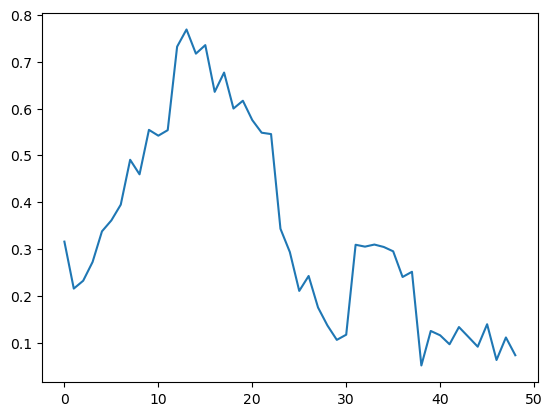

In [32]:
a = create_percentage_plots('kerala', 'Mango (all varieties)-Mangifera indica', 2023)
plt.plot(a.keys(),a.values())

In [ ]:
for week in df["Week"].sort_values().unique():
    cit_df_year_week = cit_df_year[cit_df_year['Week'] == week]
    if len(cit_df_year_week) == 0:
        pcts.append(0)
    else:
        n_data_with_attr_one = len(cit_df_year_week[cit_df_year_week[transition_attr] >= 1]) # TODO - weight values of 2?
        pcts.append(n_data_with_attr_one / len(cit_df_year_week))